# Exercise 1)

In [1]:
library(aaltobda)
data("bioassay")

In [2]:
## prior distribution

prior_mean <- c(0,10)
cov_xy     <- 0.6 * 10 * 2

prior_cov  <- array(c( 2**2, cov_xy , cov_xy, 10**2 ), dim = c(2,2) )

print(prior_cov)

     [,1] [,2]
[1,]    4   12
[2,]   12  100


## a)

This exercise asks to compute the density ratio of a metropolis hasting (i.e when the proposal distribution is symetric). By letting $q(\alpha,\beta \mid y,x,n) \propto p(y | x , n, \alpha, \beta ) p(\alpha,\beta)$ and letting $x^*$ and $x^{(t-1)}$ denote the current and previous states respectively, this density ratio is computed as:

$$
r = \frac{ p(y | x , n, \alpha^*, \beta^*) p(\alpha^*, \beta^*)}{p(y | x , n, \alpha^{t-1}, \beta^{t-1}) p(\alpha^{t-1}, \beta^{t-1})} = \\
%
%
\exp\left(\log p(y | x , n, \alpha^*, \beta^*) + \log p(\alpha^*, \beta^*) - \log p(y | x , n, \alpha^{(t-1)}, \beta^{(t-1)}) -\log p(\alpha^{(t-1)}, \beta^{(t-1)}) \right)
$$

In [3]:
density_ratio <- function( alpha_propose, alpha_previous, beta_propose, beta_previous, x, y, n ){
    
    ## ====================================
    ## Log Likelihood of the proposed state
    llh_propose <- bioassaylp( alpha_propose, beta_propose, x, y, n )
    
    ## ====================================
    ## Log Likelihood of the current state
    llh_previous <- bioassaylp( alpha_previous, beta_previous, x, y, n )
    
    ## ====================================
    ## Log Prior of the proposed state
    joint_proposal <- c(alpha_propose, beta_propose)
    lprior_propose <- log(dmvnorm(joint_proposal, prior_mean, prior_cov))
    
    ## ====================================
    ## Log Prior of the current state
    joint_proposal  <- c(alpha_previous, beta_previous)
    lprior_previous <- log(dmvnorm(joint_proposal, prior_mean, prior_cov))

    ## returned value
    exp( llh_propose + lprior_propose - llh_previous - lprior_previous )
}

In [4]:
density_ratio(  alpha_propose = 1.89, alpha_previous = 0.374,
                beta_propose = 24.76, beta_previous = 20.04,
                x = bioassay$x, y = bioassay$y, n = bioassay$n )

[1] 1.305179

In [5]:
density_ratio(  alpha_propose = 0.374, alpha_previous = 1.89,
                beta_propose = 20.04, beta_previous = 24.76,
                x = bioassay$x, y = bioassay$y, n = bioassay$n )

[1] 0.7661784

In [6]:
sample_from_proposal <- function( mean_alpha, mean_beta, proposal_cov ){
    
    mean   <- c( mean_alpha, mean_beta )
    sample <- rmvnorm(1, mean, proposal_cov)
    sample
    
}

metropolis_bioassay <- function( num_itets, x, y, n, proposal_cov, joint_initial_points ){
    
    ## preallocate memory
    gen_samples = matrix(0, num_itets, 2) # each row represent a sample, first column represents alpha and second beta
    
    ## set seed
    set.seed(1)
    
    ## Initial points
    alpha_previous <- joint_initial_points[1]
    beta_previous  <- joint_initial_points[2]
    
    for ( itet in 1:num_itets )
    {
        ## get a proposal
        sample_propose <- sample_from_proposal( alpha_previous, beta_previous, proposal_cov )
        
        alpha_propose  <- sample_propose[1]
        beta_propose   <- sample_propose[2]
        
        ## Evaluate the log density ratio
        r <- density_ratio(  alpha_propose  = alpha_propose, 
                             alpha_previous = alpha_previous,
                             beta_propose   = beta_propose,
                             beta_previous  = beta_previous,
                             x              = x, 
                             y              = y, 
                             n              = n
                          )
        ## Compute the acceptance probability
        acc_prob = min(1,r)
        
        # accept the sample directly
        if ( acc_prob == 1 )
        {
            alpha_previous <- alpha_propose
            beta_previous  <- beta_propose
        }
        # accept with probability acc_prob
        else
        {
            u <- runif(1, 0, 1)
            if ( u <= acc_prob ) # accept the sample
            {
                alpha_previous <- alpha_propose
                beta_previous  <- beta_propose
            }
        }
        ## add the sample to the chain of samples
        gen_samples[ itet, ] = c( alpha_previous, beta_previous )
        
        
    }
    
    gen_samples
}

In [7]:
proposal_cov <- array(c( 1, 0, 0, 5 ), dim = c(2,2) )
num_itets    <- 1000

set.seed(1)
joint_initial_points  <- rmvnorm(1, prior_mean, prior_cov)

post_samples <- metropolis_bioassay( num_itets, bioassay$x, bioassay$y, bioassay$n, proposal_cov, joint_initial_points )

In [8]:
post_alpha <- post_samples[,1]
post_beta  <- post_samples[,2]

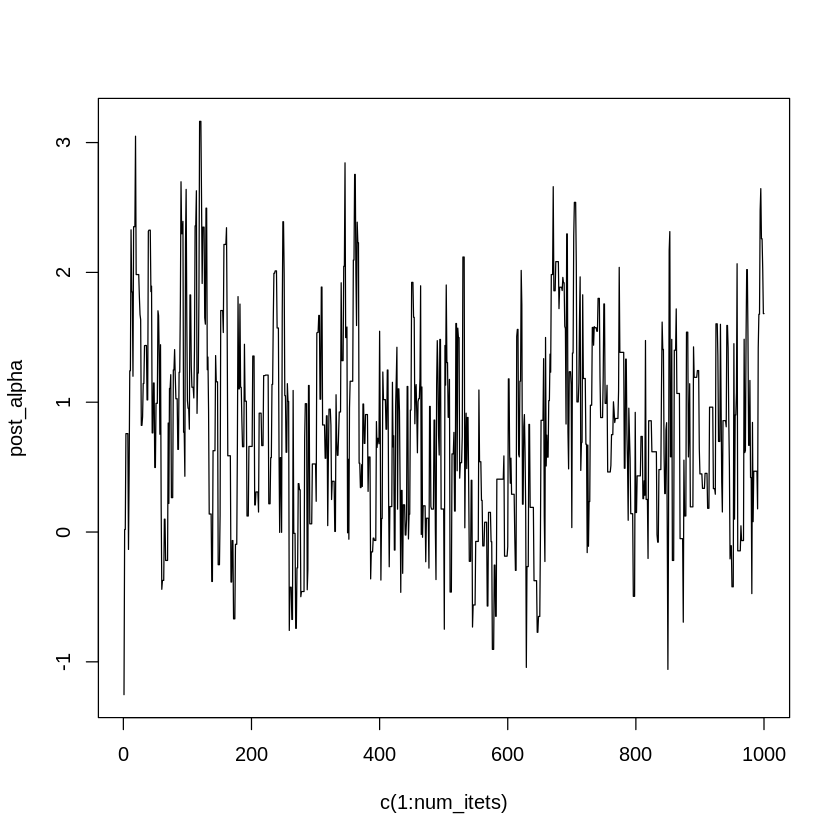

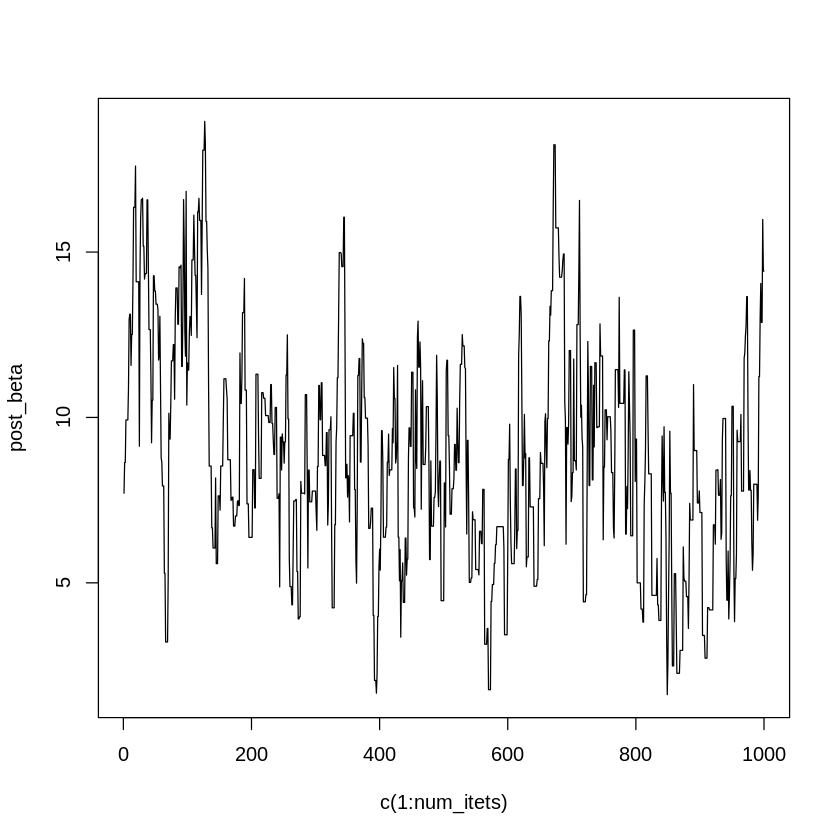

In [9]:
plot( c(1:num_itets) , post_alpha, type = 'l')
plot( c(1:num_itets) , post_beta, type = 'l')

#### comments

* with this first proposal and 1000 iterations it seems it has converge, at least for $\alpha$. For $\beta$ it seems there is density around the value of 20, so with 1000 draws the chain does not look to have converged. Also it seems some samples are being rejected for post beta in this case. Running 10000 samples looks like the chain has converged. The warm up period seems to be small.

* We should obviously need to run different chains to see if this distribution is multimodal. Carefull study could be done on the interaction between the parameters of the likelihood and the prior to see if it can induce a multimodal distribution. Since the prior is symmetric it can be the case that different combinations of negative and possitive $\alpha$ and $\beta$ samples could yield different likelihood evaluations that induce a multimodal distribution. For example if the behaviour is the same for both parameters being possitive and negative, and different for the other case (e.g. no likelihood), then the posterior would be multimodal.  

In [10]:
proposal_cov <- array( c( 0.01, 0, 0, 0.05 ), dim = c(2,2) )
num_itets    <- 1000
set.seed(1)
joint_initial_points  <- rmvnorm(1, prior_mean, prior_cov)
post_samples <- metropolis_bioassay( num_itets, bioassay$x, bioassay$y, bioassay$n, proposal_cov, joint_initial_points )

In [11]:
post_alpha <- post_samples[,1]
post_beta  <- post_samples[,2]

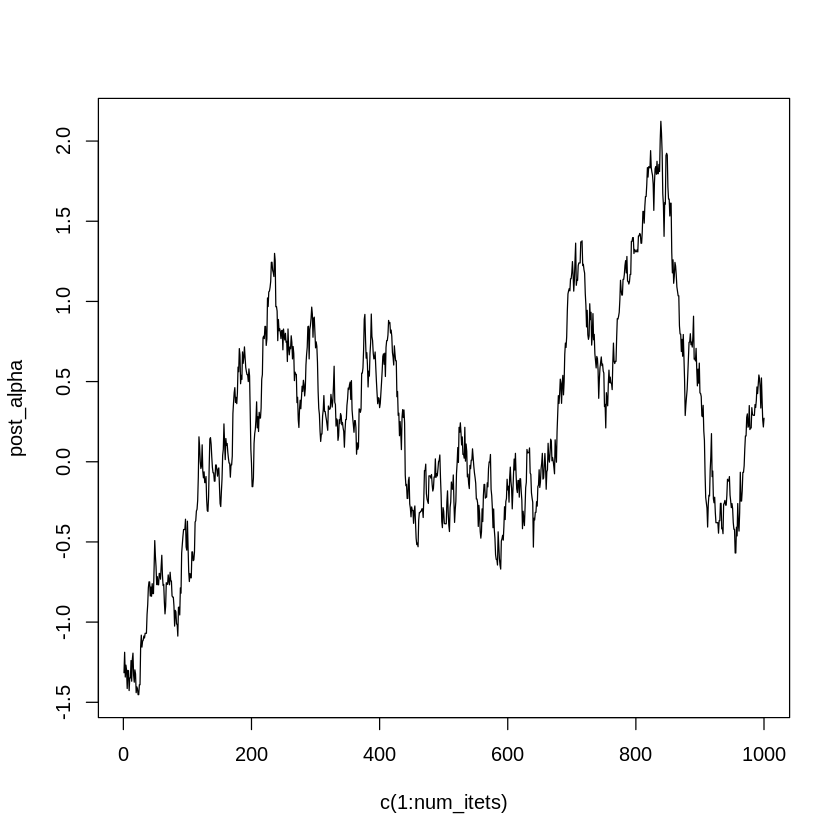

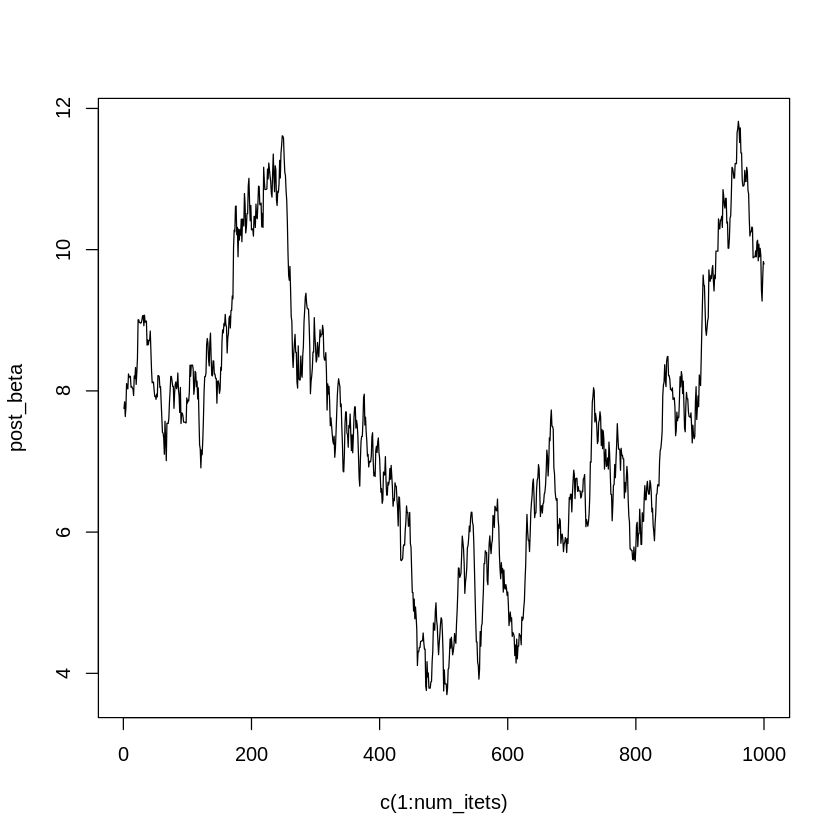

In [12]:
plot( c(1:num_itets) , post_alpha, type = 'l')
plot( c(1:num_itets) , post_beta, type = 'l')

#### comments

* clearly if the variances are very small we can see the samples are very correlated. Also comparing to the above plots and the same initial distribution it requires like 150-200 samples of warm up. We see that beta is initialized in the typical set and so no warm up period appears. If we run 10000 iterations we still see this high period of burn in. The chain seems to have converge although the exploration of the space is very innefficient (very low effectiv sample size). We are sampling from the posterior but very few independent samples.

In [13]:
proposal_cov <- array(c( 10, 0, 0, 50 ), dim = c(2,2) )
num_itets    <- 1000
set.seed(1)
joint_initial_points  <- rmvnorm(1, prior_mean, prior_cov)
post_samples <- metropolis_bioassay( num_itets, bioassay$x, bioassay$y, bioassay$n, proposal_cov, joint_initial_points )

In [14]:
post_alpha <- post_samples[,1]
post_beta  <- post_samples[,2]

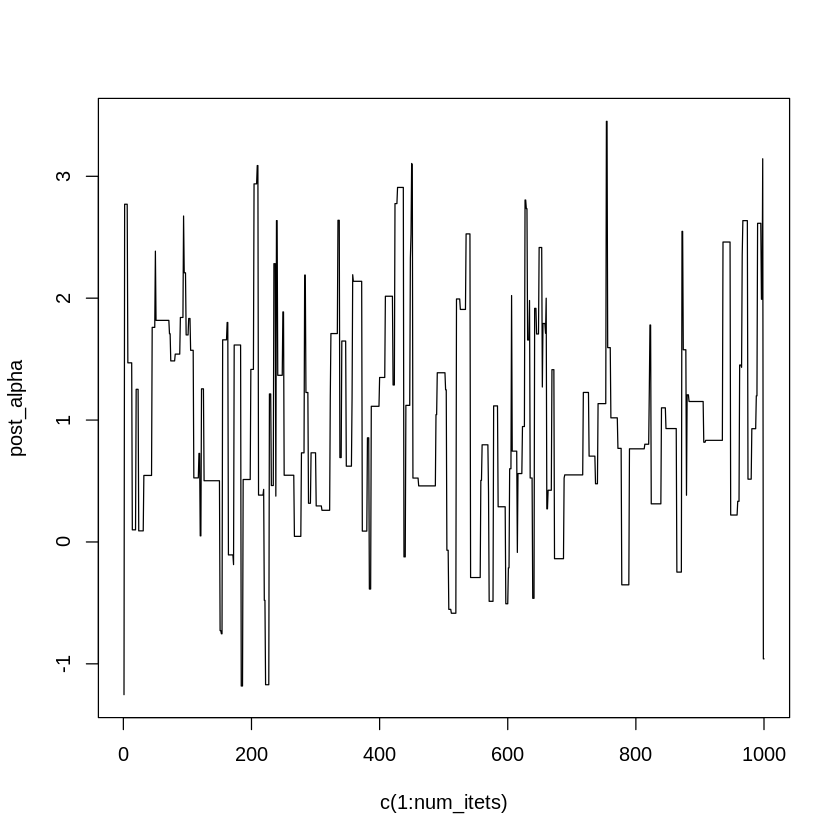

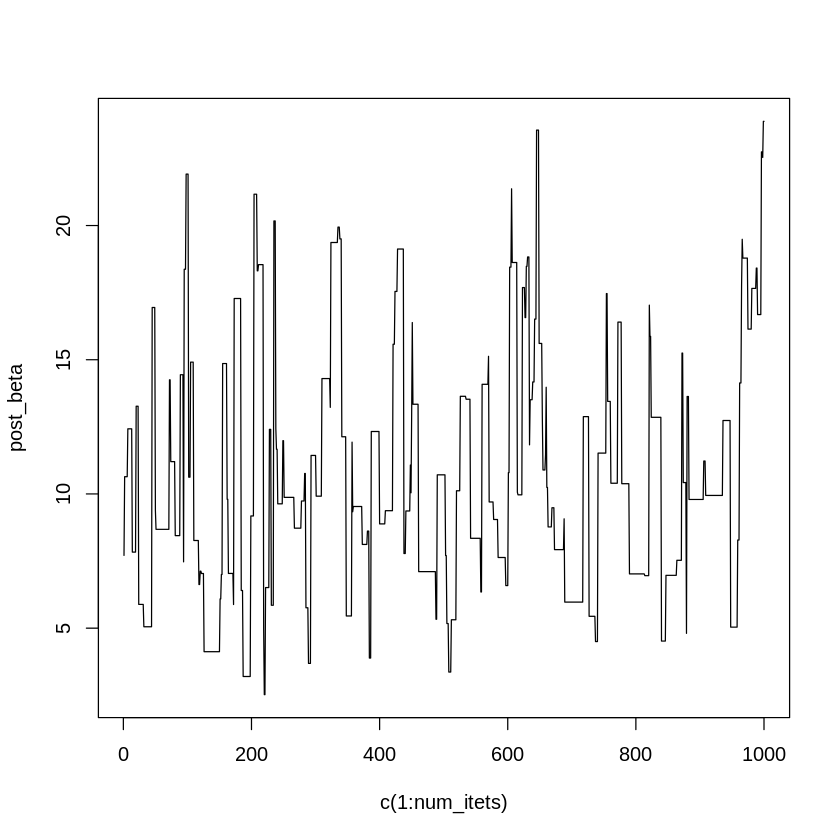

In [15]:
plot( c(1:num_itets) , post_alpha, type = 'l')
plot( c(1:num_itets) , post_beta, type = 'l')

#### comments

* Finally a huge variance makes a lot of rejections which imply low effective sample size although we have reach the stationary distribution as seen by the plot. Also the warm up since neglectible.

In [16]:
## Let's estimate the mean and covariance from the generated samples with the proposal distribution proposed in
#  the exercise.
new_cov  <- cov( post_samples )
print(new_cov)

          [,1]      [,2]
[1,] 0.7449867  2.019653
[2,] 2.0196527 19.592175


In [17]:
proposal_cov <- array( c( 0.6587693, 1.537969, 1.5379690, 13.354337 ), dim = c(2,2) )
num_itets    <- 1000

set.seed(1)
joint_initial_points  <- rmvnorm(1, prior_mean, prior_cov)

post_samples <- metropolis_bioassay( num_itets, bioassay$x, bioassay$y, bioassay$n, proposal_cov, joint_initial_points )

In [18]:
post_alpha <- post_samples[,1]
post_beta  <- post_samples[,2]

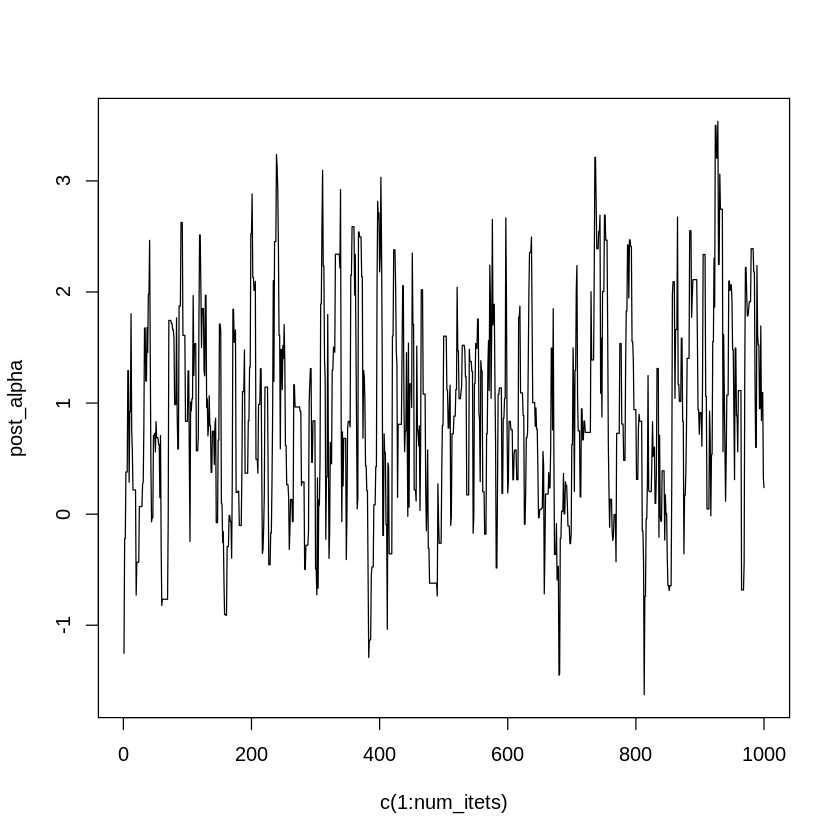

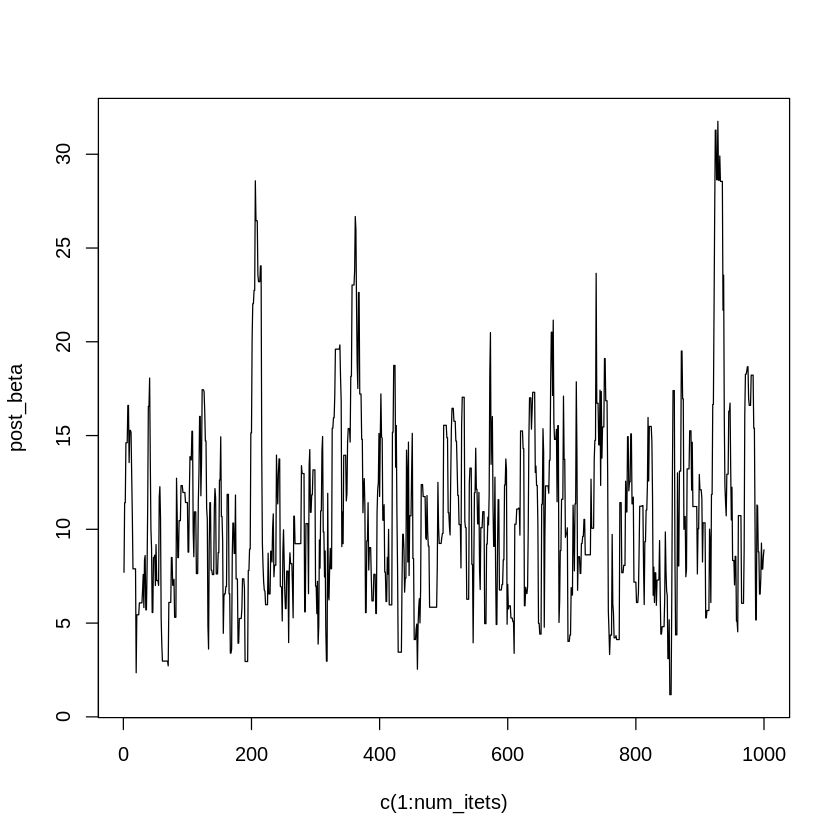

In [19]:
plot( c(1:num_itets) , post_alpha, type = 'l')
plot( c(1:num_itets) , post_beta, type = 'l')

#### Comments

* I have know take into account part of the geometry of the target distribution. In particular since the proposal distribution is Gaussian, I can estimate part of the curvature of the posterior space ( I say part since covariance only measure linear dependencies ), and now use this curvature in the proposal distribution. Thus, given a point in the sample space I am generating a new sample following the curvature of the posterior space, and so it is very likely that the new generated sample is a good candidate from the posterior distribution. Obviously this works if the posterior space is locally Gaussian with this constant curvature. We could imagine that the proposal distribution is generating a candidate that somehow follows the same directions of high-low posterior mass ( attending only to linear Gaussian dependencies ). 

* The last paragraph can be understood also as follows. The best proposal distribution is the actual posterior. So the closest we are the better the approximation.

* In the most optimistic case our posterior distributon is Gaussian and I am using its same covariance (with different mean) so nearly I am sampling directly from the posterior distribution. We can see from the plots that the chains are much more stationary than before and have mixed well. 

# Exercise 2)

## a)

The basic idea of the metropolis algorithm is to generate samples attending to the following two criterias. If the new sample has higher posterior density than the previous then we accept it. If it has lower density we accept it depending on this ratio, so if we generate a sample with very low density w.r.t. the actual point, then the probability of accepting it will be very low 

## b)

Already explained in the paragraphs I already written. I basically estimate the covariance from the posterior and use it. 

## c)

I have drawn a sample from the prior. If I where to run multiple chains, I will use initializations exploring different parts from the prior. Another idea could be to run maximum a posteriori optimization and use the estimated value, although that is no good since sometimes the MAP value is far from the typical set. So perhaps it is better to run variational inference or something like that and use the estimated posterior mean. 

In [20]:
proposal_cov <- array( c( 0.6587693, 1.537969, 1.5379690, 13.354337 ), dim = c(2,2) )
num_itets    <- 10000

set.seed(1)
joint_initial_points  <- rmvnorm(1, prior_mean, prior_cov)

post_samples <- metropolis_bioassay( num_itets, bioassay$x, bioassay$y, bioassay$n, proposal_cov, joint_initial_points )

In [21]:
post_alpha <- post_samples[,1]
post_beta  <- post_samples[,2]

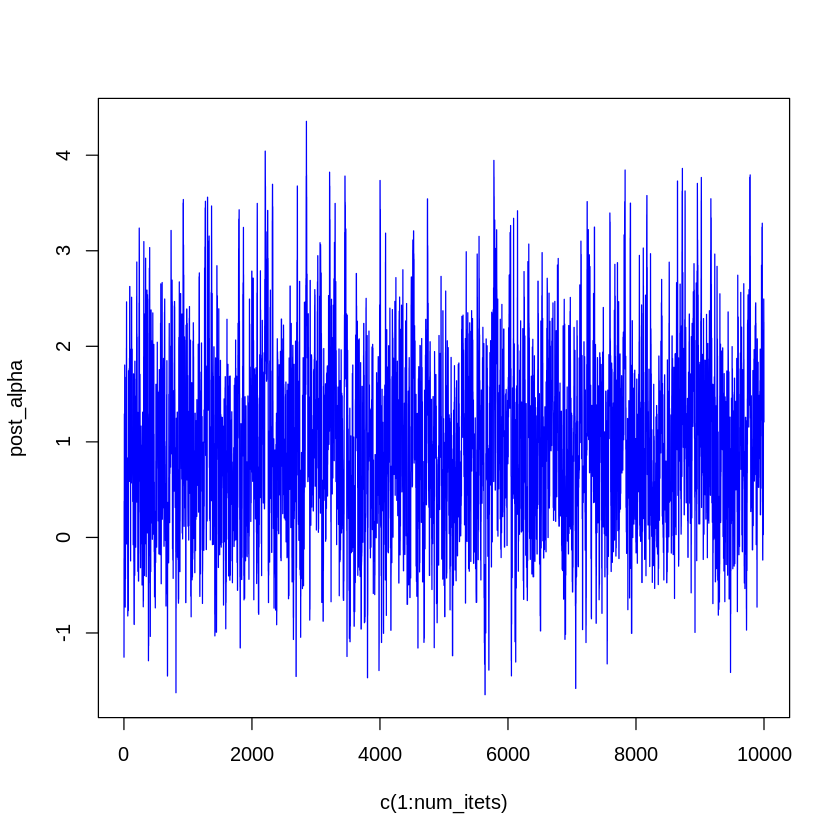

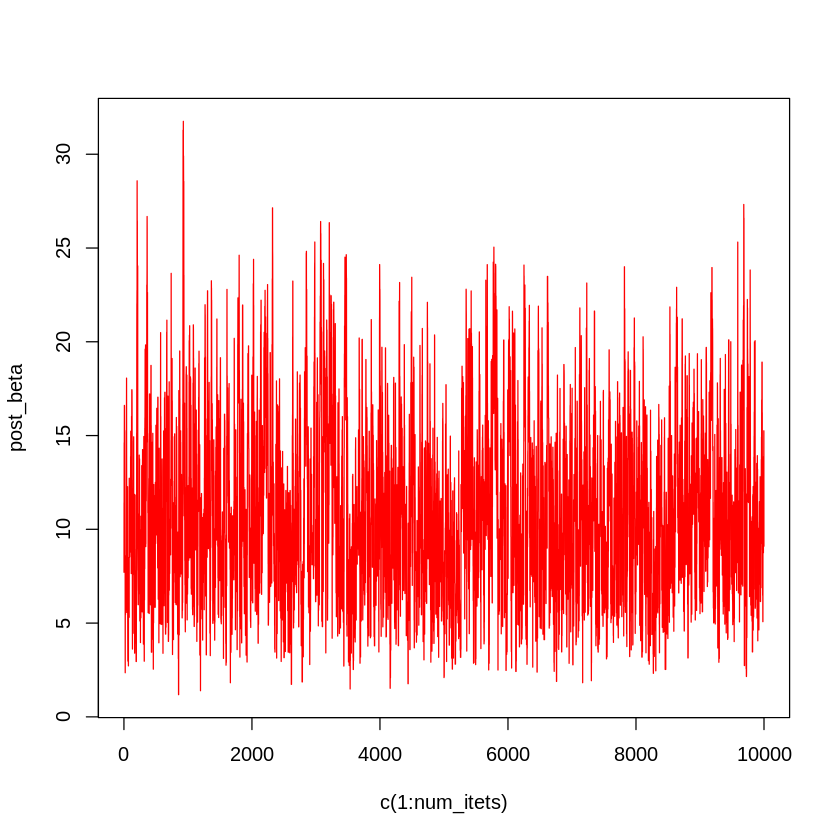

In [22]:
plot( c(1:num_itets) , post_alpha, type = 'l' , col = 'blue')
plot( c(1:num_itets) , post_beta,  type = 'l' , col = 'red' )

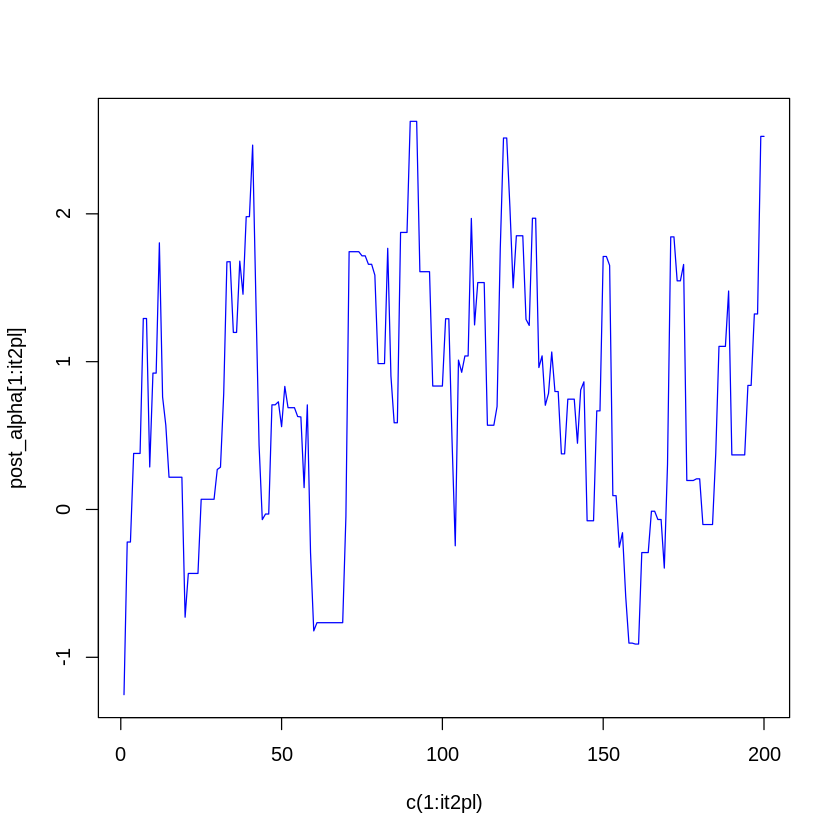

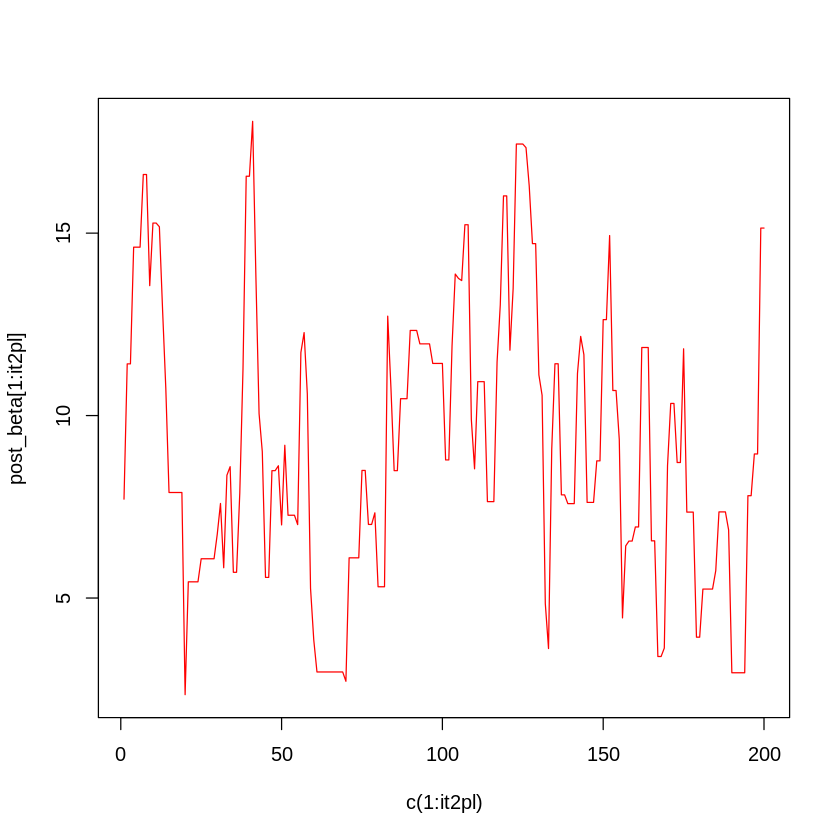

In [23]:
it2pl = 200

plot( c(1:it2pl) , post_alpha[1:it2pl], type = 'l', col = 'blue' )
plot( c(1:it2pl) , post_beta[1:it2pl],  type = 'l', col = 'red')

## d) , e)

Honestly, I do think the warm up period is neglible by looking at the plots. By looking both at 1000 and 10000 samples drawn. 

## f) , g), h)

Run with 4 chains which is the default. We observe the chains have converged.

In [24]:
# copying this funciton since with new R I needed to make some modifications

dmvnorm_mod <- function(x, mean, sigma, log = FALSE) {
  checkmate::assertNumeric(mean, any.missing = FALSE, min.len = 2)
  checkmate::assertMatrix(sigma, any.missing = FALSE, min.rows = 2, min.cols = 2)
  checkmate::assert(dim(sigma)[1] == dim(sigma)[2],
                    .var.name = 'check that covariance matrix is square')
  checkmate::assert(dim(sigma)[1] == length(mean),
                    .var.name = 'check that mean vector and covariance matrix have matching sizes')
  checkmate::assertLogical(log, len = 1)

  checkmate::assert(checkmate::checkMatrix(x),checkmate::checkVector(x))

  if (all(class(x) == c("matrix","array"))) {
    checkmate::assert(dim(x)[2] == length(mean),
                      .var.name = 'check that x has correct dimensions')
  }
  else if (class(x) == "numeric") {
    checkmate::assert(length(x) == length(mean),
                      .var.name = 'check that x has correct length')
  }



  if (is.vector(x))
    x <- matrix(x, ncol = length(x))
  cholesky <- chol(sigma)
  tmp <- backsolve(cholesky, t(x) - mean, transpose = TRUE)
  xMx <- colSums(tmp ^ 2)
  ret <- - 0.5 * (ncol(x) * log(2 * pi) + 2* sum(log(diag(cholesky))) + xMx)
  if (log) {
    ret
  }
  else {
    exp(ret)
  }
}


In [25]:
# the initial point I have been using
set.seed(1)
joint_initial_points_1  <- c(-2,0)

# I will use points around the mean of the Gaussian distribution (one possibility would be to use eigenvectors)
joint_initial_points_2 <- c(-2,19)

joint_initial_points_3 <- c(1.5,0)

joint_initial_points_4 <- c(1.5,19)

joint_initial_points = t(matrix( c(joint_initial_points_1, joint_initial_points_2, joint_initial_points_3, joint_initial_points_4 ), nrow = 2))

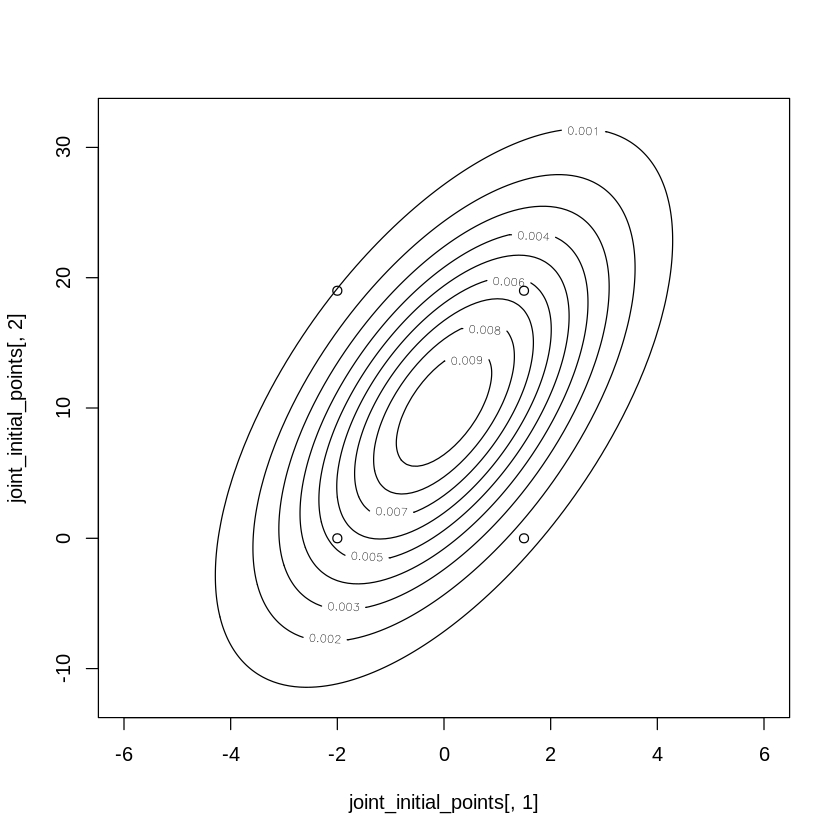

In [26]:
x       <- seq(-6, 6, 0.1) 
y       <- seq(-12, 32, 0.1)

f     <- function(x, y) dmvnorm_mod( matrix(c(x, y), ncol = 2), prior_mean, prior_cov)
z     <- outer(x, y, f)

#create contour plot
plot(joint_initial_points[,1],joint_initial_points[,2], xlim = range(-6:6), ylim = range(-12:32))
contour(x, y, z, add = TRUE)


In [27]:
proposal_cov <- array( c( 0.6587693, 1.537969, 1.5379690, 13.354337 ), dim = c(2,2) )
num_itets    <- 1000

chain_1 <- metropolis_bioassay( num_itets, bioassay$x, bioassay$y, bioassay$n, proposal_cov, joint_initial_points_1 )

chain_2 <- metropolis_bioassay( num_itets, bioassay$x, bioassay$y, bioassay$n, proposal_cov, joint_initial_points_2 )

chain_3 <- metropolis_bioassay( num_itets, bioassay$x, bioassay$y, bioassay$n, proposal_cov, joint_initial_points_3 )

chain_4 <- metropolis_bioassay( num_itets, bioassay$x, bioassay$y, bioassay$n, proposal_cov, joint_initial_points_4 )

In [28]:
chains     <- list(chain_1, chain_2, chain_3, chain_4)
post_alpha <- list()
post_beta  <- list()

counter = 1
for (ch in chains)
{

  post_alpha[[counter]] <- ch[,1]  
  post_beta[[counter]]  <- ch[,2] 

  counter <- counter + 1
}


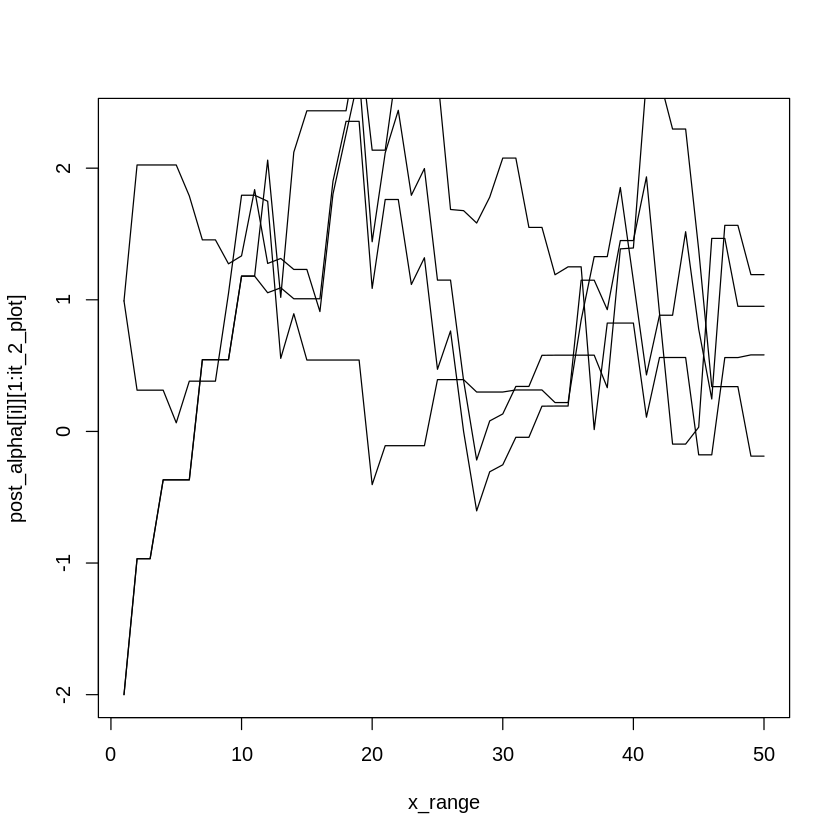

In [29]:
## Alpha posterior
it_2_plot = 50
x_range   = c(1:it_2_plot)
for ( i in 1:length(post_alpha) )
{
    if (i == 1)
    {
        plot( x_range , post_alpha[[i]][1:it_2_plot], type = 'l' )
    }
    else
    {
        lines( x_range , post_alpha[[i]][1:it_2_plot] )
    }
}

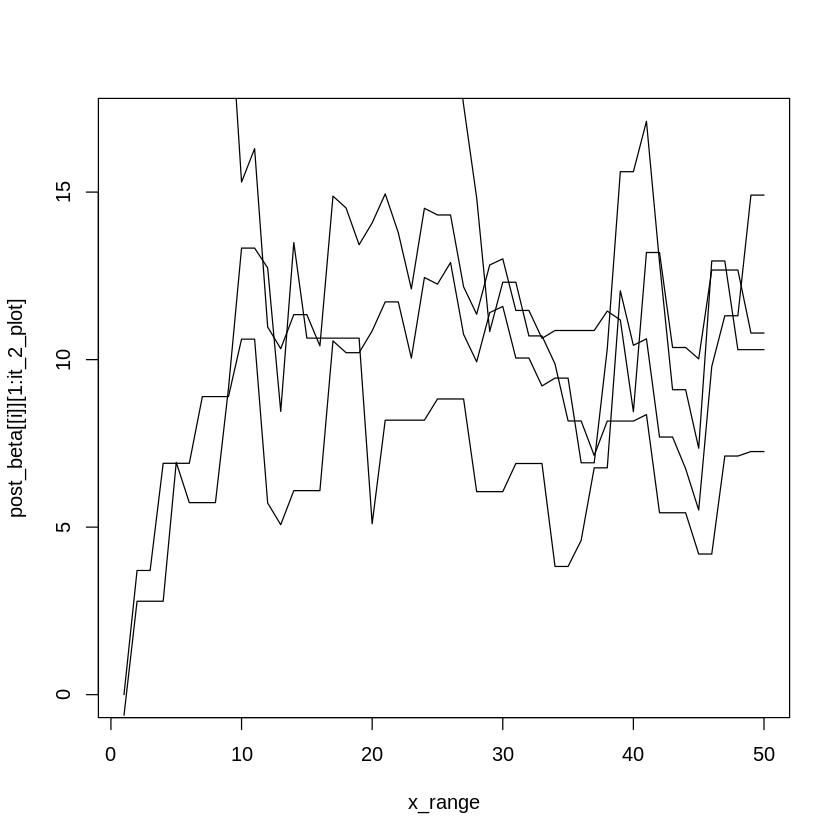

In [30]:
## Beta posterior
it_2_plot = 50
x_range   = c(1:it_2_plot)
for ( i in 1:length(post_beta) )
{
    if (i == 1)
    {
        plot( x_range , post_beta[[i]][1:it_2_plot], type = 'l' )
    }
    else
    {
        lines( x_range , post_beta[[i]][1:it_2_plot] )
    }
}

## Exercise 3)

In [31]:
# install.packages("posterior")
library(posterior)

This is posterior version 1.3.1


Attaching package: ‘posterior’


The following object is masked from ‘package:aaltobda’:

    mcse_quantile


The following objects are masked from ‘package:stats’:

    mad, sd, var




In [32]:
## convert into a matrix of num_iterations x num_chains and remove warm_up
warm_up    <- 50
matrix_aux <- matrix(0,num_itets - warm_up,4)

i = 1
for (cn in post_alpha)
{
    matrix_aux[,i] <- tail(cn, num_itets - warm_up)
    i = i+1
}
post_alpha <- matrix_aux

i = 1
for (cn in post_beta)
{
    matrix_aux[,i] <- tail(cn, num_itets - warm_up)
    i = i + 1
}  
post_beta <- matrix_aux

In [33]:
# alpha Rhat
rhat(post_alpha)

[1] 1.006987

In [34]:
# beta Rhat
rhat(post_beta)

[1] 1.009232

## a)

The Rhat is a summary that measures the difference between the variance of a chain and the variance of all the samples from all the chains. The idea is that since convergence to the stationary distribution is achieved when all the chains have traversed the posterior parameter space in an equal way, then the variance of a single chain would be the same as if all the samples from all the samples are joined. 

## b)

I have obtained good Rhat values since they are below the recomended value of 1.01. I observed that 50 warm up samples where necessary (which we can see in the trace plot that they belong to a warm up phase, specially for the beta posterior parameter). I haven't modified the proposal distribution since I already did an initial analysis at the beginning of the exercise.

# Exercise 4)

In [35]:
dim(post_alpha) <- c(( num_itets - warm_up ) * 4 )
dim(post_beta)  <- c(( num_itets - warm_up ) * 4 )

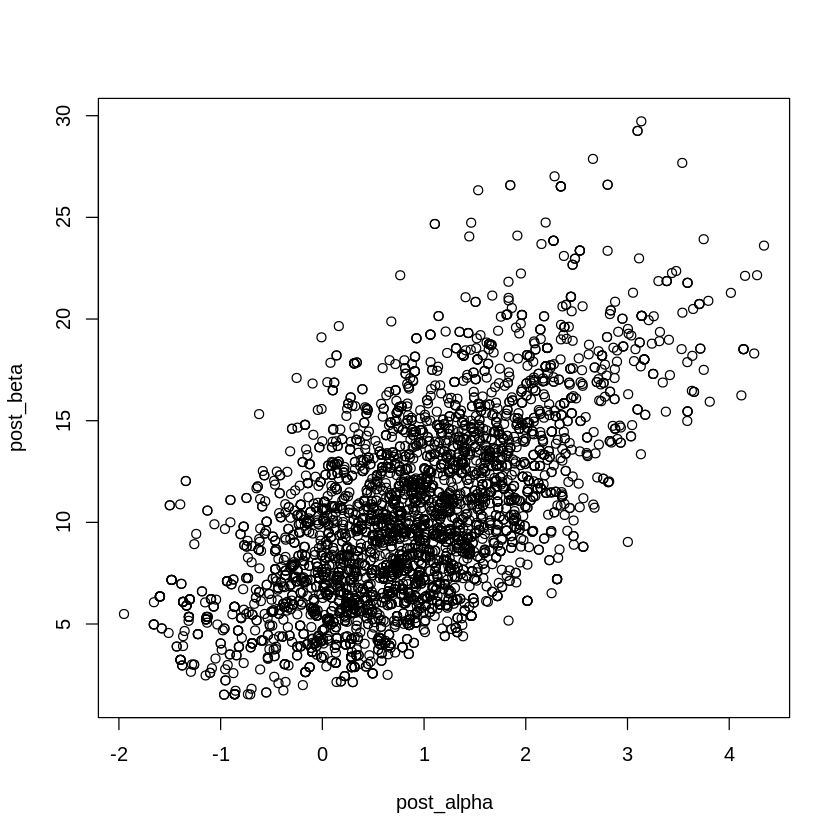

In [36]:
plot(post_alpha,post_beta)

In [37]:
library(markmyassignment)
assignment_path <-
paste("https://github.com/avehtari/BDA_course_Aalto/,
blob/master/assignments/tests/assignment5.yml", sep="")
set_assignment(assignment_path)
# To check your code/functions, just run
mark_my_assignment()

Assignment set:
assignment5: Bayesian Data Analysis: Assignment 5
The assignment contain the following task:
- density_ratio




✔ | F W S  OK | Context
✔ |         6 | density_ratio()

══ Results ════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
[ FAIL 0 | WARN 0 | SKIP 0 | PASS 6 ]
You're a coding rockstar!

#### I'm a rockstar